In [25]:
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u

import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
exp = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
mc = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
exp['angErr'][exp['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
mc['angErr'][mc['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

exp['ra']=np.random.uniform(0,2*np.pi,size=len(exp))
grl = np.load("/data/i3store/users/mjlarson/student_data/GRL/IC86_2012_exp.npy")
livetime = np.sum(grl['livetime'])


In [26]:
from imp import reload
reload(IceCubeLike)

import warnings
warnings.filterwarnings("ignore")

IceCube=IceCubeLike.IceCubeLike("test",exp,mc,exp,verbose=True)


In [30]:
source1_sp = Powerlaw()
#source1_sp._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1_sp.K=1e-13
source1_neutrino = Powerlaw()
source1_neutrino.K=1e-10
source1_neutrino.index=-2
#source1_sp._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1 = PointSource("source1", ra=83.63, dec=22.0145, spectral_shape=source1_sp)
source1_nu = IceCubeLike.NeutrinoPointSource("source1_nu",ra=83.63, dec=22.0145,spectral_shape=source1_neutrino)
model = Model(source1,source1_nu)
model.source1.spectrum.main.Powerlaw.K.fix = True
model.source1.spectrum.main.Powerlaw.index.fix = True
model.source1_nu.spectrum.main.Powerlaw.index.fix = True
IceCubedata = DataList(IceCube)
jl = JointLikelihood(model, IceCubedata)

In [12]:
#data = np.random.choice(exp, 10000).copy()
#jl._data_list['test'].llh_model.update_data(data)

In [39]:
a=jl._data_list['test'].llh_model

In [44]:
(a.energy>1).sum()/len(a.energy)

0.18888334165418538

In [31]:
best_fit_parameters, likelihood_values = jl.fit()

(9.259317866790928, 124.08199072819897)
(9.302057613149193, 124.46971809081225)


RuntimeError: exception was raised in user function
User function arguments:
    source1_nu_spectrum_main_Powerlaw_K = -10.002000
Original python exception in user function:
KeyboardInterrupt: 
  File "/data/disk01/home/jasonfan/threeML/threeML/classicMLE/joint_likelihood.py", line 745, in minus_log_like_profile
    this_log_like = dataset.inner_fit()
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 216, in inner_fit
    return self.get_log_like()
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 209, in get_log_like
    self.update_model()
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 200, in update_model
    self.llh_model.update_spectrum(self.spectrum)
  File "/data/disk01/home/jasonfan/umd_icecube_analysis_tutorial/mla/mla/core.py", line 302, in update_spectrum
    self.update_energy_histogram()
  File "/data/disk01/home/jasonfan/umd_icecube_analysis_tutorial/mla/mla/core.py", line 378, in update_energy_histogram
    sig_w/=np.sum(self.fullsim['ow'] * self.spectrum(self.fullsim['trueE']))
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 116, in __call__
    return self.model._point_sources[self.neutrinopointsource].call(E)
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 51, in call
    results = [component.shape(x) for component in list(self.components.values())]
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 51, in <listcomp>
    results = [component.shape(x) for component in list(self.components.values())]
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/functions/function.py", line 911, in __call__
    return self.fast_call(x)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/memoization.py", line 58, in memoizer
    return method(instance, x, *args, **kwargs)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/functions/function.py", line 986, in fast_call
    return self.evaluate(x, *values)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/functions/functions.py", line 212, in evaluate
    return K * np.power(xx, index)


In [33]:
test=np.linspace(0,jl._data_list['test'].llh_model.N,10000)
ts=[]
for i in test:
    ts.append(jl._data_list['test'].llh_model.eval_llh_ns(i)[1])

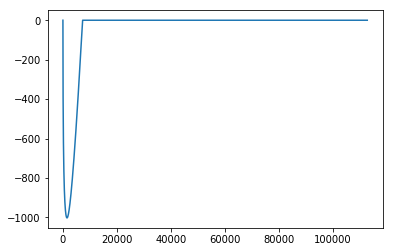

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt, colors
plt.plot(test,np.array(ts)*-1)

In [45]:
from mla.core import LLH_point_source
dec = 22.0145*np.pi/180
ra = 83.63*np.pi/180
b=LLH_point_source(ra,dec,exp,mc,spectrum="PowerLaw",background=exp,background_time_profile=(50000,60000))

In [46]:
b.eval_llh_fit_ns()

(1805.156212017375, 1376.9432351463106)

In [49]:
(b.energy>1).sum()/len(b.energy)
    

0.7422754756753758

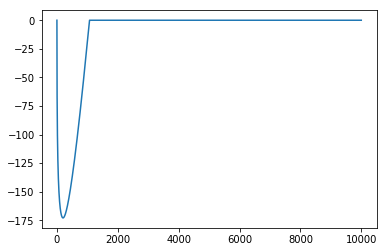

In [12]:
best_fit_parameters, likelihood_values = jl.fit()

(9.259317866790928, 136.66301478673412)
(9.302057613149193, 137.09524890356624)
(9.216773352013972, 136.2318704761255)
(9.269770118971488, 136.76880223900054)
(9.248877331361523, 136.55729273890302)
(9.298086671150076, 137.01175499475522)
(9.220717248088501, 136.31499079094547)
(9.271015714390483, 136.76832567182015)
(9.247635377862638, 136.55776930608044)
(9.269770118971488, 136.76880223900054)
(9.311696556640452, 137.19260651947923)
(9.417339248874878, 138.2567059770755)
(9.741469443856769, 141.4885228520177)


RuntimeError: exception was raised in user function
User function arguments:
        source1_nu_spectrum_main_Powerlaw_K = -9.933883
    source1_nu_spectrum_main_Powerlaw_index = -2.000000
Original python exception in user function:
KeyboardInterrupt: 
  File "/data/disk01/home/jasonfan/threeML/threeML/classicMLE/joint_likelihood.py", line 745, in minus_log_like_profile
    this_log_like = dataset.inner_fit()
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 216, in inner_fit
    return self.get_log_like()
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 209, in get_log_like
    self.update_model()
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 200, in update_model
    self.llh_model.update_spectrum(self.spectrum)
  File "/data/disk01/home/jasonfan/umd_icecube_analysis_tutorial/mla/mla/core.py", line 302, in update_spectrum
    self.update_energy_histogram()
  File "/data/disk01/home/jasonfan/umd_icecube_analysis_tutorial/mla/mla/core.py", line 378, in update_energy_histogram
    sig_w/=np.sum(self.fullsim['ow'] * self.spectrum(self.fullsim['trueE']))
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 116, in __call__
    return self.model._point_sources[self.neutrinopointsource].call(E)
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 51, in call
    results = [component.shape(x) for component in list(self.components.values())]
  File "/data/disk01/home/jasonfan/threeML/threeML/plugins/IceCubeLike.py", line 51, in <listcomp>
    results = [component.shape(x) for component in list(self.components.values())]
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/functions/function.py", line 911, in __call__
    return self.fast_call(x)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/memoization.py", line 58, in memoizer
    return method(instance, x, *args, **kwargs)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/functions/function.py", line 986, in fast_call
    return self.evaluate(x, *values)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/functions/functions.py", line 212, in evaluate
    return K * np.power(xx, index)


In [11]:
from imp import reload
reload(IceCubeLike)
IceCube=IceCubeLike.IceCubeLike("test",exp,mc,exp,background_time_profile=(0,1))

source1_sp = Powerlaw()
#source1_sp._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1_sp.K=1e-13
source1_neutrino = Powerlaw()
source1_neutrino.K=1e-6

#source1_sp._set_units(u.GeV,u.cm**-2 / u.s / u.GeV)
source1 = PointSource("source1", ra=83.63, dec=22.0145, spectral_shape=source1_sp)
source1_nu = IceCubeLike.NeutrinoPointSource("source1_nu",ra=83.63, dec=22.0145,spectral_shape=source1_neutrino)
model = Model(source1,source1_nu)
model.source1.spectrum.main.Powerlaw.K.fix = True
model.source1.spectrum.main.Powerlaw.index.fix = True
model.source1_nu.spectrum.main.Powerlaw.index.bounds = (-4,-1)
#model.source1_nu.spectrum.main.Powerlaw.K.bounds = (1e-5 * 1 / (u.cm**2 * u.s * u.TeV),10.0 * 1 / (u.cm**2 * u.s * u.TeV))
IceCubedata = DataList(IceCube)
jl = JointLikelihood(model, IceCubedata)
data=np.load("testdata.npy")
data['time']=0.5
jl._data_list['test'].llh_model.update_data(data)


In [ ]:
%timeit best_fit_parameters, likelihood_values = jl.fit()

Best fit values:



,result,unit
parameter,,
source1_nu.spectrum.main.Powerlaw.K,(1.2 -1.0 +6) x 10^-4,1 / (cm2 keV s)
source1_nu.spectrum.main.Powerlaw.index,-2.38 +/- 0.19,



Correlation matrix:



1.00,-1.00
-1.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
test,-275.087937
total,-275.087937



Values of statistical measures:



,statistical measures
AIC,-552.175873
BIC,-550.175873


Best fit values:



,result,unit
parameter,,
source1_nu.spectrum.main.Powerlaw.K,(1.2 -1.0 +6) x 10^-4,1 / (cm2 keV s)
source1_nu.spectrum.main.Powerlaw.index,-2.38 +/- 0.19,



Correlation matrix:



1.00,-1.00
-1.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
test,-275.087969
total,-275.087969



Values of statistical measures:



,statistical measures
AIC,-552.175937
BIC,-550.175937


Best fit values:



,result,unit
parameter,,
source1_nu.spectrum.main.Powerlaw.K,(1.2 -1.0 +6) x 10^-4,1 / (cm2 keV s)
source1_nu.spectrum.main.Powerlaw.index,-2.38 +/- 0.19,



Correlation matrix:



1.00,-1.00
-1.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
test,-275.087969
total,-275.087969



Values of statistical measures:



,statistical measures
AIC,-552.175937
BIC,-550.175937


Best fit values:



,result,unit
parameter,,
source1_nu.spectrum.main.Powerlaw.K,(1.2 -1.0 +6) x 10^-4,1 / (cm2 keV s)
source1_nu.spectrum.main.Powerlaw.index,-2.38 +/- 0.19,



Correlation matrix:



1.00,-1.00
-1.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
test,-275.087969
total,-275.087969



Values of statistical measures:



,statistical measures
AIC,-552.175937
BIC,-550.175937


Best fit values:



,result,unit
parameter,,
source1_nu.spectrum.main.Powerlaw.K,(1.2 -1.0 +6) x 10^-4,1 / (cm2 keV s)
source1_nu.spectrum.main.Powerlaw.index,-2.38 +/- 0.19,



Correlation matrix:



1.00,-1.00
-1.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
test,-275.087969
total,-275.087969



Values of statistical measures:



,statistical measures
AIC,-552.175937
BIC,-550.175937
